In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build vocab of chs and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [7]:
# train/test split 80-10-10
# build the dataset
def build_dataset(words, block_size=3):
    
#     block_size: context length: how many chs do we take to predict the next one. It's fixed here. 
    X, Y = [], []
    for w in words:
    #     print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
    #         print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

block_size=3

Xtr, Ytr = build_dataset(words[:n1], block_size)
Xdev, Ydev = build_dataset(words[n1:n2], block_size)
Xte, Yte = build_dataset(words[n2:], block_size)


torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [73]:
# MLP revisited
n_emb = 10 # dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator=g)
# kaiming init
W1 = torch.randn((n_emb * block_size, n_hidden), generator=g) * (5/3)/((n_emb * block_size)**0.5)
# b1 = torch.randn((n_hidden,), generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn((vocab_size, ), generator=g) * 0

# batchnorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12297


In [74]:
# same optimization as in the youtube video that got beaten by us increasing block_size
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    
    # linear layer
    # b1 is no needed because bnbias is enough
    hpreact = embcat @ W1 # + b1 # hidden layer pre activation
    # batchnorm layer
    #------------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdims=True)
    bnstdi = hpreact.std(0, keepdims=True)
    hpreact = bngain * (hpreact - bnmeani)/(bnstdi + 1e-5) + bnbias
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    #------------------------------------------------------------------
    # non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backwoard pass
    for p in parameters: 
        p.grad = None
    loss.backward()
    # update

    if i < max_steps/2:
        lr = 0.1
    else:
        lr = 0.01
    for p in parameters: 
        p.data += -lr * p.grad
        
    # keep stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3014
  10000/ 200000: 2.4789
  20000/ 200000: 2.3364
  30000/ 200000: 2.1072
  40000/ 200000: 2.0523
  50000/ 200000: 2.4329
  60000/ 200000: 2.2905
  70000/ 200000: 2.0826
  80000/ 200000: 2.0123
  90000/ 200000: 2.0183
 100000/ 200000: 2.4473
 110000/ 200000: 2.0486
 120000/ 200000: 2.1925
 130000/ 200000: 2.3583
 140000/ 200000: 2.2693
 150000/ 200000: 2.3672
 160000/ 200000: 2.0888
 170000/ 200000: 2.0872
 180000/ 200000: 2.4111
 190000/ 200000: 1.8808


In [67]:
# calibrate the batch norm at the end of training
# do not need in practice. using running mean and std instead
with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim = True)
    bnstd = hpreact.std(0, keepdim = True)

In [75]:
@torch.no_grad() # this decorator disables gradient tracking 
def split_loss(split):
    x, y={
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x] #(N, block_size, n_emb)
    embcat = emb.view(emb.shape[0], -1) # efficient concat into (N, block_size*n_emb)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean_running)/bnstd_running + bnbias

    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.065549850463867
val 2.111138343811035


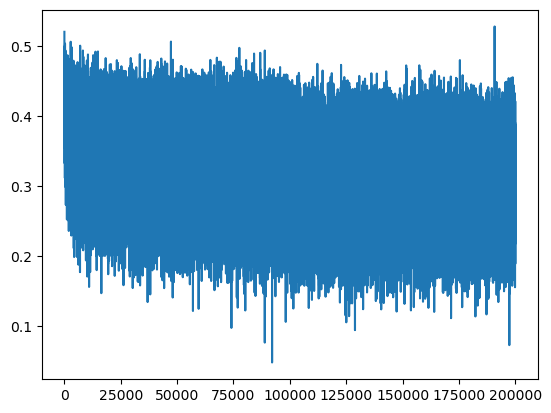

In [50]:
plt.plot(range(max_steps), lossi)

In [76]:
# sample from the model 
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    block_size = 3
    out = []
    context = [0] * block_size
    while True: 
        emb = C[torch.tensor([context])] #(1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim = 1)
        ix = torch.multinomial(probs, num_samples=1, generator = g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix==0:
            break
    print(''.join(itos[i] for i in out))

chrizhxatsllisshlimrix.
thtlshrcassachrishbnlexerystilrquiffrryssstchmihvonsleggbrhlmarlissqubythn.
lillissadbbigguthn.
difryxisshmedrightleesdepli.
trissleystryshudgmidhj.
ksyannaqiosozswylljs.
falassrendkp.
sadlulussonssachryshubnstaqlalrynn.
thidelieoqbarubrbdayaf.
qwentlgbrichridgkylansluwrkoluwza.
quintdyk.
khnnskannezsmeseff.
khardylio.
rosbyktorknnykirrightlinszes.
stleomisnnysresslynn.
zyxbarubillah.
samrysshykhnnyshktoryaslujhveousslsunnersxlynn.
tzlltz.
stzy.
rvelinslunniyannysklminncygurvelianaypsdafrrixeidhton.


In [79]:
class Linear: 
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g)/fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momemtum update')
        self.running_mean = torch.zeroes(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) #batch mean
            xvar = x.var(0, keepdim=True, unbiased=True)  #batch var
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean)/torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update with buffers
        if self.training: 
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momemtum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh: 
    def __call__(self, x): 
        self.out = torch.tanh(x)
        return self.out
    def parameters(self): 
        return []
    
n_embd = 10 # the dim of the character embedding vectors
n_hidden = 100 # number of neurons in the hiddeln layer
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(), 
    Linear(n_hidden, n_hidden), Tanh(), 
    Linear(n_hidden, n_hidden), Tanh(), 
    Linear(n_hidden, n_hidden), Tanh(), 
    Linear(n_hidden, vocab_size),
]

with torch.no_grad():
    # last layer: make less confident 
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
            
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement()) for p in parameters)
for p in parameters: 
    p.requires_grad = True

<generator object <genexpr> at 0x7fc413b45070>
